# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [130]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

Код для расчёта энтропии:

In [131]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [132]:
def count_info_gain(r_v, r_left, r_right):
    left, right = len(r_left) / len(r_v), len(r_right) / len(r_v)
    return entropy(r_v) - left * entropy(r_left) - right * entropy(r_right)


class Node:
    def __init__(self, probabilities=None):
        self.right = None
        self.left = None
        self.probabilities = probabilities
        self.feature_index = None
        self.t = -1


class DecisionTreeClassifier:
    def __init__(
        self,
        max_depth: int = 5,
        min_samples_leaf: int = 5,
    ):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = None
        self.tree = None

    def probabilities(self, y):
        return np.array([len(y[y == y_type]) / len(y) for y_type in range(self.n_classes)])

    def _is_stop_condition(self, y, depth, leaf_samples):
        over_depth = depth >= self.max_depth
        not_enough_samples = len(y) < leaf_samples
        purity = len(np.unique(y)) == 1
        return over_depth or not_enough_samples or purity

    def split_node(self, X, y, node, depth=0):
        if self._is_stop_condition(y, depth, self.min_samples_leaf):
            return

        feature_index, best_t = self._find_best_split(X, y)
        if feature_index is None:
            return

        x_left, y_left = X[X[:, feature_index] < best_t], y[X[:, feature_index] < best_t]
        x_right, y_right = X[X[:, feature_index] >= best_t], y[X[:, feature_index] >= best_t]

        node.left = Node(self.probabilities(y_left))
        node.right = Node(self.probabilities(y_right))
        node.feature_index = feature_index
        node.t = best_t
        self.split_node(x_left, y_left, node.left, depth + 1)
        self.split_node(x_right, y_right, node.right, depth + 1)


    @staticmethod
    def _find_best_split(X, y):
        best_idx, best_thr, best_ig = None, None, -1
        for i in range(X.shape[1]):
            x_col = X[:, i]
            for t in x_col:
                r_left, r_right = y[x_col < t], y[x_col >= t]
                ig = count_info_gain(y, r_left, r_right)
                if ig > best_ig:
                    best_thr, best_ig, best_idx = t, ig, i

        return best_idx, best_thr

    def fit(self, X, y):
        self.n_classes = len(np.unique(y))
        self.tree = Node(self.probabilities(y))
        self.split_node(np.asarray(X), y, self.tree)

    def predict(self, X):
        return [np.argmax(self.predict_node(x, self.tree)) for x in X]

    def predict_node(self, x, node):
        while node.left:
            if x[node.feature_index] < node.t:
                return self.predict_node(x, node.left)
            else:
                return self.predict_node(x, node.right)

        return node.probabilities

In [133]:
from sklearn.datasets import load_iris

iris = load_iris()

In [134]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

decision_tree = DecisionTreeClassifier(max_depth=5)
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

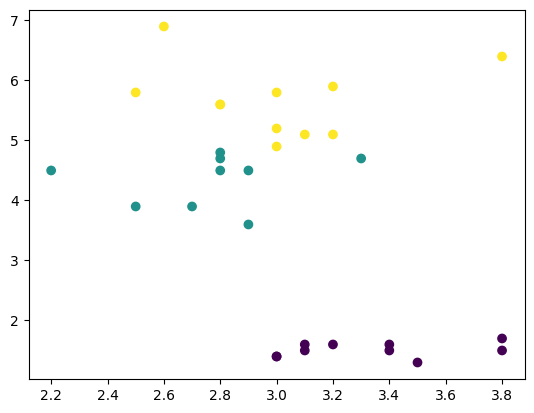

In [135]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_pred)

In [136]:
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier

sklearn_decision_tree = SklearnDecisionTreeClassifier(max_depth=5, min_samples_leaf=5)
sklearn_decision_tree.fit(X_train, y_train)
y_pred = sklearn_decision_tree.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

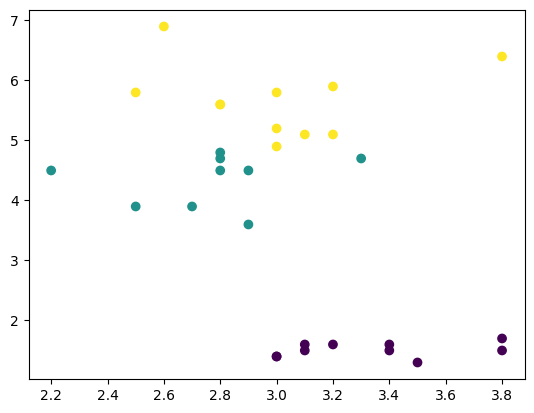

In [137]:
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_pred)

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес".

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [138]:
class RandomForestClassifier:
    def __init__(
        self,
        tree_count: int = 50,
        tree_max_depth: int = 5,
        tree_min_samples_leaf: int = 5
    ):
        self.tree_count = tree_count
        self.tree_max_depth = tree_max_depth
        self.tree_min_samples_leaf = tree_min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        objects_count = X.shape[0]
        features_count = X.shape[1]

        for _ in range(self.tree_count):
            random_state = np.random.randint(0, 1000)
            X_sample = X.sample(n=objects_count, replace=True, random_state=random_state)
            y_sample = y[X_sample.index]

            tree = SklearnDecisionTreeClassifier(
                max_depth=self.tree_max_depth,
                min_samples_leaf=self.tree_min_samples_leaf,
                random_state=random_state,
                max_features=int(np.sqrt(features_count))
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0).round().astype(int)

    def feature_importances(self):
        return np.mean([tree.feature_importances_ for tree in self.trees], axis=0)


In [139]:
!pip install kaggle category_encoders


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [140]:
!kaggle datasets download -d mathchi/churn-for-bank-customers -p ./data

churn-for-bank-customers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [141]:
!unzip ./data/churn-for-bank-customers.zip -d ./data

Archive:  ./data/churn-for-bank-customers.zip
  inflating: ./data/churn.csv        


In [142]:
churn = pd.read_csv('./data/churn.csv')
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [143]:
import warnings
warnings.filterwarnings('ignore')

from category_encoders import TargetEncoder

target = churn['Exited']
geography_encoder = TargetEncoder()
churn['Geography'] = geography_encoder.fit_transform(churn['Geography'], target)

In [144]:
gender_encoder  = TargetEncoder()
churn['Gender'] = gender_encoder.fit_transform(churn['Gender'], target)

In [145]:
churn = churn.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)

In [146]:
churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,0.161548,0.250715,42,2,0.00,1,1,1,101348.88
1,608,0.166734,0.250715,41,1,83807.86,1,0,1,112542.58
2,502,0.161548,0.250715,42,8,159660.80,3,1,0,113931.57
3,699,0.161548,0.250715,39,1,0.00,2,0,0,93826.63
4,850,0.166734,0.250715,43,2,125510.82,1,1,1,79084.10


In [162]:
max_tree_count_options = [10, 50, 100, 200, 500]
max_depth_options = list(range(1, 10))
min_samples_leaf_options = list(range(1, 5))


def get_best_params(
    X,
    y,
):
    best_params = None
    best_score = 0

    for max_tree_count in max_tree_count_options:
        for max_depth in max_depth_options:
            for min_samples_leaf in min_samples_leaf_options:
                print(f'Fitting with params: {max_tree_count}, {max_depth}, {min_samples_leaf}')
                model = RandomForestClassifier(
                    tree_count=max_tree_count,
                    tree_max_depth=max_depth,
                    tree_min_samples_leaf=min_samples_leaf
                )
                model.fit(X, y)
                score = accuracy_score(y, model.predict(X))
                if score > best_score:
                    best_score = score
                    best_params = {
                        'tree_count': max_tree_count,
                        'tree_max_depth': max_depth,
                        'tree_min_samples_leaf': min_samples_leaf
                    }
    return best_params, best_score

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    churn,
    target,
    test_size=0.2,
    random_state=42
)

In [164]:
best_params, best_score = get_best_params(X_train, y_train)

Fitting with params: 10, 1, 1
Fitting with params: 10, 1, 2
Fitting with params: 10, 1, 3
Fitting with params: 10, 1, 4
Fitting with params: 10, 2, 1
Fitting with params: 10, 2, 2
Fitting with params: 10, 2, 3
Fitting with params: 10, 2, 4
Fitting with params: 10, 3, 1
Fitting with params: 10, 3, 2
Fitting with params: 10, 3, 3
Fitting with params: 10, 3, 4
Fitting with params: 10, 4, 1
Fitting with params: 10, 4, 2
Fitting with params: 10, 4, 3
Fitting with params: 10, 4, 4
Fitting with params: 10, 5, 1
Fitting with params: 10, 5, 2
Fitting with params: 10, 5, 3
Fitting with params: 10, 5, 4
Fitting with params: 10, 6, 1
Fitting with params: 10, 6, 2
Fitting with params: 10, 6, 3
Fitting with params: 10, 6, 4
Fitting with params: 10, 7, 1
Fitting with params: 10, 7, 2
Fitting with params: 10, 7, 3
Fitting with params: 10, 7, 4
Fitting with params: 10, 8, 1
Fitting with params: 10, 8, 2
Fitting with params: 10, 8, 3
Fitting with params: 10, 8, 4
Fitting with params: 10, 9, 1
Fitting wi

In [165]:
print(f'Best params: {best_params}', f'Best score: {best_score}', sep='\n')

Best params: {'tree_count': 50, 'tree_max_depth': 9, 'tree_min_samples_leaf': 1}
Best score: 0.886375


In [166]:
model = RandomForestClassifier(
    tree_count=best_params['tree_count'],
    tree_max_depth=best_params['tree_max_depth'],
    tree_min_samples_leaf=best_params['tree_min_samples_leaf']
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.864


In [167]:
pd.DataFrame({
    'feature': churn.columns,
    'importance': model.feature_importances()
}).sort_values('importance', ascending=False)

,feature,importance
3,Age,0.331526
6,NumOfProducts,0.252547
5,Balance,0.099386
8,IsActiveMember,0.073364
0,CreditScore,0.064288
9,EstimatedSalary,0.064238
1,Geography,0.054356
4,Tenure,0.034179
2,Gender,0.017883
7,HasCrCard,0.008233


In [168]:
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier

sklearn_model = SklearnRandomForestClassifier(
    n_estimators=best_params['tree_count'],
    max_depth=best_params['tree_max_depth'],
    min_samples_leaf=best_params['tree_min_samples_leaf'],
    random_state=42
)

sklearn_model.fit(X_train, y_train)

sklearn_y_pred = sklearn_model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, sklearn_y_pred)}')

Accuracy: 0.861


In [169]:
pd.DataFrame({
    'feature': churn.columns,
    'importance': sklearn_model.feature_importances_
}).sort_values('importance', ascending=False)

,feature,importance
3,Age,0.341690
6,NumOfProducts,0.253271
5,Balance,0.099159
8,IsActiveMember,0.068170
0,CreditScore,0.062768
9,EstimatedSalary,0.062474
1,Geography,0.051503
4,Tenure,0.035072
2,Gender,0.018524
7,HasCrCard,0.007369
